Great- Let's build on our last example and set you up for varying thermodynamics parameters

Last time we did this:
1. Turn on hoomd-blue, a simulation engine that works nicely in python
1. Load in a configuration of randomly-packed spheres that has been created for us
1. Define Lennard-Jones interaction rules and an NVT ensemble
1. Set up a logger that will save simulation information we can use.
1. Step forward 10000 steps.
1. Plot kinetic temperature

This time we are going to :
1. Turn on hoomd-blue, a simulation engine that works nicely in python
1. Load in a configuration of randomly-packed spheres that has been created for us
1. Define Lennard-Jones interaction rules and an __NPT__ ensemble
    1. We're going to vary the integrator parameters and evaluate thermodynamic observables
1. Set up a logger that will save simulation information we can use.
1. Step forward __10,0000__ steps.
1. Analyze output



In [1]:
import hoomd
import gsd.hoomd
from day1_utils import arrays_from_gsd
import matplotlib.pyplot as plt

In [2]:
#This is steps 1-3 from before
# Attach to CPU and create simulation
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu,seed=0)
sim.create_state_from_gsd(filename='random.gsd') #N and V are set here

#Potential and integrator setup
integrator = hoomd.md.Integrator(dt=0.005)
cell = hoomd.md.nlist.Cell(buffer = 0.4)
lj_potential = hoomd.md.pair.LJ(nlist=cell)
lj_potential.params[('A','A')] = dict(epsilon=1,sigma=1)
lj_potential.r_cut[('A','A')]=2.5
T,P = 1.5, 3.0 #NEW
ensemble = hoomd.md.methods.NPT(kT=T,filter=hoomd.filter.All(),tau=.1, tauS=0.1, S=P, couple = 'xyz') #NEW
integrator.forces.append(lj_potential)
integrator.methods.append(ensemble)
sim.operations.integrator = integrator

# Set the simulation state 
sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.5)



In [3]:
# We need to define which atoms participate in logging, what's logged, and where to store that info.
selection = hoomd.filter.All() # "which atoms"
logger = hoomd.logging.Logger() # will be used for "what's logged"
trajfile = 'traj3.gsd'
writer = hoomd.write.GSD(filename=trajfile, # "where to store"
                             trigger=hoomd.trigger.Periodic(100), #when to store
                             mode='wb',
                             filter=selection) #filter=hoomd.filter.Null() to only store log

thermo_props = hoomd.md.compute.ThermodynamicQuantities(filter=selection) # What to store
logger.add(thermo_props)
logger.add(sim,quantities=['timestep','walltime','tps'])
writer.log = logger #need to tell our write which logger to use when it's logging info

sim.operations.computes.append(thermo_props) #tell our simulation to *compute* the thermo properties
sim.operations.writers.append(writer) # tell our simulation which writer(s) to use


In [4]:
# Run  the simulation  (a few seconds)
sim.run(1e5)

In [5]:
# Use the log to analyze properties
traj = gsd.hoomd.open(trajfile,'rb')
traj[0].log #let's see what things we can access in the log

{'md/compute/ThermodynamicQuantities/kinetic_temperature': array([1.35531094]),
 'md/compute/ThermodynamicQuantities/pressure': array([5.48293575]),
 'md/compute/ThermodynamicQuantities/pressure_tensor': array([ 6.16431824, -0.0800075 ,  0.15555493,  5.66618896,  0.29488547,
         4.61830004]),
 'md/compute/ThermodynamicQuantities/kinetic_energy': array([518.40643306]),
 'md/compute/ThermodynamicQuantities/translational_kinetic_energy': array([518.40643306]),
 'md/compute/ThermodynamicQuantities/rotational_kinetic_energy': array([0.]),
 'md/compute/ThermodynamicQuantities/potential_energy': array([-1130.50699638]),
 'md/compute/ThermodynamicQuantities/degrees_of_freedom': array([765.]),
 'md/compute/ThermodynamicQuantities/translational_degrees_of_freedom': array([765.]),
 'md/compute/ThermodynamicQuantities/rotational_degrees_of_freedom': array([0.]),
 'md/compute/ThermodynamicQuantities/num_particles': array([256]),
 'md/compute/ThermodynamicQuantities/volume': array([318.64920867

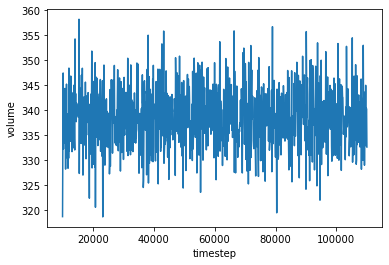

In [6]:
x = 'timestep'
y = 'volume'
[xd,yd] = arrays_from_gsd(trajfile,keys=[x,y])
plt.plot(xd,yd)
plt.xlabel(x)
plt.ylabel(y)
plt.show()

In [7]:
import numpy
def calc_density(filename):
    with gsd.hoomd.open(filename,'rb') as traj:
        N = len(traj[0].particles.position)
        step = []
        vol = []
        for frame in traj:
                step.append(frame.configuration.step)
                vol.append(frame.log['md/compute/ThermodynamicQuantities/volume'][0])
        return numpy.array(step), numpy.array(vol)/N 

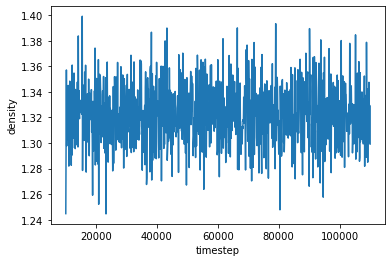

In [8]:
step, density = calc_density(trajfile)
plt.plot(step,density)
plt.xlabel("timestep")
plt.ylabel("density")
plt.show()

In [9]:
print(T, P, density.mean(), density.std())

1.5 3.0 1.32202089047001 0.02347698751080215


In [ ]:
#TODO: Put job in a loop?